## 1. Cleanup
Find the sample dataset of request logs in data/DataSample.csv. We consider records that have identical geoinfo and timest as suspicious. Please clean up the sample dataset by filtering out those questionable request records.

In [1]:
import os
import pandas as pd
import math
import numpy as np
df = pd.read_csv(os.path.expanduser('data/DataSample.csv'))
poi = pd.read_csv(os.path.expanduser('data/POIList.csv'))

In [2]:
df = df.drop_duplicates(subset=[' TimeSt', 'Longitude', 'Latitude']) # drop records that are the same if they're from these three subsets

# Let's rename some of these to take out spaces, and cut down on typing throughout
df = df.rename(columns = {' TimeSt': 'TimeSt','Latitude':'lat', 'Longitude':'lon'})
poi=poi.rename(columns = {' Latitude':'lat', 'Longitude':'lon'})
poi.duplicated(subset=['lon', 'lat'])

0    False
1     True
2    False
3    False
dtype: bool

### Just in case we need it later we can create record of any POI's that might share the same location

In [3]:
poi_dups = poi.duplicated(subset=['lon', 'lat'])


In [4]:
poi_dups[poi_dups].index

Int64Index([1], dtype='int64')

## 2. Label
Assign each request (from data/DataSample.csv) to the closest (i.e., minimum distance) POI (from data/POIList.csv).

Note: a POI is a geographical Point of Interest.

## Nearest Neighbor
The naive approach to this calculation is to just calculate the distance from a user record, to each of the POI's, while keeping track of the closest one, and then to label the user record at the end with the closest POI. This time scales at O(N).
We can do better!
To calculate which POI is closest, we're going to use a method called Ball Tree, which uses a decision tree in 3D space to determine the nearest neighbor to a selected query point.
sklearn has an implementation of it, but we can develop the code ourself if need be. This package has an option for Haversine as the metric to be used.
This time scales at an average of O(logN), a considerable improvement.


### Distances on a globe
With the distances involved, we can't project to a 2D plane and calculate from there, we have to take into account the curvature of the globe.
For that we'll need an equation called the Haversine equation, which can take in two longitude and latitude points, and return the distance between them

### Naive Approach

In [5]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

def find_nearest(lat, long):
    distances = poi.apply(
        lambda row: haversine(lat, long, row['lat'], row['lon']), 
        axis=1)
    return poi.loc[distances.idxmin(), 'POIID']

In [6]:
test = df.copy()

In [7]:
%%timeit
test['POI'] = test.apply(
    lambda row: find_nearest(row['lat'], row['lon']), 
    axis=1)

11.2 s ± 298 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Ball Tree
Ball tree approach using sklearns neighbors implementation, which should take about O(logN)

In [8]:
%%timeit
from sklearn.neighbors import BallTree

bt = BallTree(np.deg2rad(poi[['lat', 'lon']].values), metric='haversine')
distances, indices = bt.query(np.deg2rad(np.c_[df['lat'], df['lon']]))


df['POI'] = indices
df['distance(km)'] = distances *6371

4.97 ms ± 151 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In this real world example, we end up running about 330 times faster than the Naive approach

Here we've labelled each of the User Records with the closest POI, as well as the distance (in km) to that point.

### Removing True Outliers
Before we go any further, lets take a look at what our data looks like projected onto a map

The geopandas, shapely, and Folium imports are just for visualization, and are not needed for the actual calculations.

The only packages needed are the imports at the top, and sklearn's Ball Tree

In [9]:
g_test = df.copy()

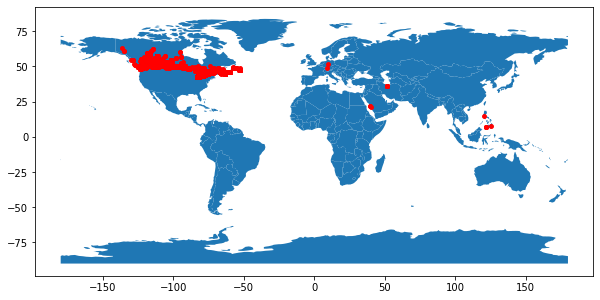

In [10]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame


geometry = [Point(xy) for xy in zip(g_test['lon'], g_test['lat'])]
gdf = GeoDataFrame(g_test, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

In [11]:
gdf['Country'].unique()

array(['CA'], dtype=object)

#### As you can see, some longitudes and latitudes are in other countries, while the country code is still only Canada.
#### The distances involved just in Canada are already pushing the realm of "close", so let's remove all points that are more than the distance between the closest and farthest POI
#### Depending on what the POI file usually looks like, we could alter this to remove more or less points, but for this, it helps to keep all the points in Canada.

In [12]:
df = df[df['distance(km)'] < (haversine(poi['lon'].max(),poi['lat'].max(),poi['lon'].min(), poi['lat'].min())/2)]

In [13]:
gdf = gdf[gdf['distance(km)'] < (haversine(poi['lon'].max(),poi['lat'].max(),poi['lon'].min(), poi['lat'].min())/2)]
g_test = g_test[g_test['distance(km)'] < (haversine(poi['lon'].max(),poi['lat'].max(),poi['lon'].min(), poi['lat'].min())/2)]

#### We end up removing 22 records, which isn't terrible for a dataset containing nearly 20,000

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19977 entries, 0 to 22024
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   _ID           19977 non-null  int64  
 1   TimeSt        19977 non-null  object 
 2   Country       19977 non-null  object 
 3   Province      19977 non-null  object 
 4   City          19977 non-null  object 
 5   lat           19977 non-null  float64
 6   lon           19977 non-null  float64
 7   POI           19977 non-null  int64  
 8   distance(km)  19977 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 1.5+ MB


### 3. Analysis
### For each POI, calculate the average and standard deviation of the distance between the POI to each of its assigned requests.
### At each POI, draw a circle (with the center at the POI) that includes all of its assigned requests. Calculate the radius and density (requests/area) for each POI.

In [15]:
poi_users = df.groupby('POI')['distance(km)'].count()
poi_mean = df.groupby('POI')['distance(km)'].mean()
poi_std = df.groupby('POI')['distance(km)'].std()

#### The number of users for each poi is: 

In [16]:
poi_users

POI
0    9720
2    9795
3     462
Name: distance(km), dtype: int64

#### The mean distance for each of the POI's to their respective users is: poi_mean

In [17]:
poi_mean

POI
0    293.910798
2    451.527555
3    238.335736
Name: distance(km), dtype: float64

#### The standard deviation for each of the groups is: 

In [18]:
poi_std

POI
0    285.183540
2    223.350558
3    224.715608
Name: distance(km), dtype: float64

#### Note that these POIID's reference the same longitude / latitude. If we had more information about them, like what class of store they represent, we could include them as separate points in an analysis.
#### As is, they can be thought of as having the same density / radii / popularity for now:

In [19]:
pd.concat(g for _, g in poi.groupby(["lat", "lon"]) if len(g) > 1)

,POIID,lat,lon
0,POI1,53.546167,-113.485734
1,POI2,53.546167,-113.485734


#### Finally, max distance for each POI (these are really large!)

In [20]:
df.groupby('POI')['distance(km)'].max()

POI
0    1684.757584
2    1474.580962
3     855.256289
Name: distance(km), dtype: float64

#### POI1, and POI2 occupy the same location, and without knowing more about them, we'll have to give them the same radii (and therefore same density)

In [21]:
poi['radius'] = round(df.groupby('POI')['distance(km)'].max(), 3)

In [22]:
poi['radius'][1] = poi['radius'][0]

<ipython-input-22-79a8831f4524>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poi['radius'][1] = poi['radius'][0]


In [23]:
poi

,POIID,lat,lon,radius
0,POI1,53.546167,-113.485734,1684.758
1,POI2,53.546167,-113.485734,1684.758
2,POI3,45.521629,-73.566024,1474.581
3,POI4,45.224830,-63.232729,855.256


### Density

Here;s the basic calculations for the density of these POI's. Later, we'll make the calculations fit with the data a little better, taking into account things like inverse distance weighting, and catchment area analysis

#### The total square kilometers for each POI based on the radii to the farthest user record is: 

In [24]:
((df.groupby('POI')['distance(km)'].max()) * math.pi ** 2)

POI
0    16627.890868
2    14553.530753
3     8441.041231
Name: distance(km), dtype: float64

#### The density per km^2 of the POI's is as follows:

In [25]:
df.groupby('POI')['_ID'].count() / ((df.groupby('POI')['distance(km)'].max()) * math.pi ** 2)

POI
0    0.584560
2    0.673033
3    0.054733
dtype: float64

Note POI1, and POI2 both represent the same location, and therefore have the same density

### Quick visualization of the density of these POI's using a heatmap, while simultaneously showing people's movement throughout the day

In [26]:
# Converting column to datetime
df['TimeSt']=pd.to_datetime(df['TimeSt'],format='%Y-%m-%d %H:%M:%S')
# Creating hour column
df['hour']=df['TimeSt'].apply(lambda x: x.hour+1)
df.head()

,_ID,TimeSt,Country,Province,City,lat,lon,POI,distance(km),hour
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123,2,593.413441,1
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090,2,677.309655,19
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010,2,569.647737,16
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730,2,634.733996,16
4,4516613,2017-06-21 15:00:00.497,CA,ON,Stratford,43.37160,-80.97730,2,634.733996,16


In [27]:
lat_long_list = []
for i in range(1,25):
    temp=[]
    for index, instance in df[df['hour'] == i].iterrows():
        temp.append([instance['lat'],instance['lon']])
    lat_long_list.append(temp)

In [30]:
# Import necessary packages
import os 
import folium
from folium import plugins
from folium.plugins import HeatMapWithTime
from folium.plugins import HeatMap
from branca.element import Figure
#Make the list of Lat an Lng
lat = df.lat.tolist()
lng = df.lon.tolist()

fig7=Figure(width=850,height=550)
m7=folium.Map(location=[56.1304, -106.3468],zoom_start=3)
fig7.add_child(m7)
poi.apply(lambda row:folium.Marker(location = [row['lat'], row['lon']],radius = (row['radius']*1000), popup=row['POIID'], fill=False).add_to(m7), axis=1)
poi.apply(lambda row:folium.Circle(location = [row['lat'], row['lon']],radius = (row['radius']*1000), popup=row['POIID'], fill=False).add_to(m7), axis=1)
HeatMapWithTime(lat_long_list,radius=10,auto_play=True,position='bottomright', name='Heat Map Time Series of User Records').add_to(m7)


HeatMap(list(zip(lat, lng)),name="Heat Map of User Records",radius=12, blur=10).add_to(m7)

folium.LayerControl().add_to(m7)

m7

A couple things regarding this representation
- It looks like the data is random, and might not be a good representation of actual POI's

- If we had maybe the origin, or data that tracked movement throughout a day, we could track the position of users at the top of an hour or at the top of every 10 minutes, and get a better idea of their movements.

- Second, the radii of the circles around the POI's is rather large, especially as there are only 3 different points across Canada, and the farthest point northward from a location or west / east from the eastern / western most points can make the circle arbitrarily large. 
- They're still within Canada, but to get a better analysis out of this, we can create convex hull polygons or catchment area analyses to better account for distances involved, and density of individuals.

# See next notebook for 4.a Model